In [1]:
from numpy.random import seed
seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
from tensorflow.python.keras.callbacks import TensorBoard

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective_2D #, plot_histogram
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
import pandas as pd
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'f1']
    
    plt.subplots(1,4,figsize=(10.5,3.5))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(1,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color='royalblue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color='royalblue', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()
        
    plt.tight_layout()
    plt.savefig('../figures/single_stateless_LSTM_learning_curves.png', bbox_inches='tight')

    
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    normalized_cm = np.empty([2, 2])
    normalized_cm[0][0] = cm[0][0] / (cm[0][0] + cm[0][1])
    normalized_cm[0][1] = cm[0][1] / (cm[0][0] + cm[0][1])
    normalized_cm[1][0] = cm[1][0] / (cm[1][0] + cm[1][1])
    normalized_cm[1][1] = cm[1][1] / (cm[1][0] + cm[1][1])
    plt.figure(figsize=(5,5))
    sns.heatmap(normalized_cm, annot=True)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No fire (True Negatives): ', cm[0][0])
    print('False alarms (False Positives): ', cm[0][1])
    print('Fires missed (False Negatives): ', cm[1][0])
    print('Fires detected (True Positives): ', cm[1][1])
    print('Total fires: ', np.sum(cm[1]))
    
    plt.tight_layout()
    plt.savefig('../figures/single_stateless_LSTM_confusion_matrix.png', bbox_inches='tight')

def multivariate_data(
    dataset,
    target, 
    start_index, 
    end_index, 
    history_size,
    target_size, 
    step
):
    
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

def log_dir_name(
    learning_rate,
    past_history,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda,
    class_0_weight,
    class_1_weight
):

    # The dir-name for the TensorBoard log-dir.
    s = "./LSTM_logs/single_stateless_past_history_{1}_hidden_layers_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(
        learning_rate,
        past_history,
        lstm_units,
        hidden_layers,
        hidden_units,
        #lstm_l2_lambda,
        hidden_l2_lambda,
        class_0_weight,
        class_1_weight
    )

    return log_dir

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * ((precision*10) * recall) / ((precision*10) + recall + K.epsilon())
    
    return f1_val

In [4]:
data_file = '../data/training_data/1992-2015_training_data_added_features.csv'

# Datatypes for dataframe loading
dtypes = {
    'lat': float,
    'lon': float,
    'weather_bin_year': int,
    'weather_bin_month': int,
    'weather_bin_day': int,
    'air.2m': float,
    'apcp': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'vis': float,
    'ignition': float,
    'mean.air.2m': float,
    'mean.apcp': float,
    'mean.rhum.2m': float,
    'mean.dpt.2m': float,
    'mean.pres.sfc': float,
    'mean.uwnd.10m': float,
    'mean.vwnd.10m': float,
    'mean.veg': float,
    'mean.vis': float,
    'max.air.2m': float,
    'max.apcp': float,
    'max.rhum.2m': float,
    'max.dpt.2m': float,
    'max.pres.sfc': float,
    'max.uwnd.10m': float,
    'max.vwnd.10m': float,
    'max.veg': float,
    'max.vis': float,
    'min.air.2m': float,
    'min.apcp': float,
    'min.rhum.2m': float,
    'min.dpt.2m': float,
    'min.pres.sfc': float,
    'min.uwnd.10m': float,
    'min.vwnd.10m': float,
    'min.veg': float,
    'min.vis': float,
    'total_fires': float

}

# Features to use during training 
features = [
    'lat',
    'lon',
    'weather_bin_month',
    'veg',
    'ignition',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.veg',
    'mean.vis',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

features_to_scale = [
    'veg',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

In [5]:
raw_data = pd.read_csv(data_file, index_col=0, parse_dates=True, dtype=dtypes)

In [6]:
# Pull out columns of intrest
data = raw_data[features]

In [7]:
# Pick one spatial bin with fires
data = data[(data['lat'] == 39.42233) & (data['lon'] == -120.6546)]

In [8]:
# Also drop lat, lon, day and year columns (unnecessary)
data.drop(['lat', 'lon'], axis=1, inplace=True)

In [9]:
# One hot encode month
column_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)

onehot_month_df['datetime'] = pd.to_datetime(data.index)
onehot_month_df = onehot_month_df.set_index('datetime')
data = pd.concat([data, onehot_month_df], axis=1)

In [10]:
# Scale data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

In [11]:
# Sort by date time index
data = data.sort_index()

In [12]:
data.head()

,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,mean.vwnd.10m,mean.veg,...,March,April,May,June,July,August,Septermber,October,November,December
1992-01-01,0.503702,0.0,-1.138237,-0.368419,-0.485131,-1.694950,0.575796,-0.787113,0.389269,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-02,0.503702,0.0,-0.916780,-0.359414,-0.717171,-1.648949,-0.455567,-0.610320,-0.105418,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-03,0.503702,0.0,-1.003120,0.155398,0.521572,-0.763310,-1.945359,0.406430,0.978409,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-04,0.503702,0.0,-1.013071,1.580237,1.798763,0.130060,-2.642089,0.746722,2.634629,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-05,0.503702,0.0,-1.245384,0.645080,1.815982,-0.175384,-3.348068,0.378398,1.619435,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.1))
leftover_data = data.iloc[:-int(len(data)*0.1)]

validation_data = data.tail(int(len(leftover_data)*0.3))
training_data = data.iloc[:-int(len(leftover_data)*0.3)]

In [14]:
# Convert to numpy arrays
training_data = np.array(training_data)
validation_data = np.array(validation_data)
test_data = np.array(test_data)

In [15]:
future_target = 1
step = 1

initial_bias = -1.4
output_bias = tf.keras.initializers.Constant(initial_bias)

# weight_for_0 = 0.5 
# weight_for_1 = 13
# class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 15
BATCH_SIZE = 100
STEPS_PER_EPOCH = (len(training_data) * 0.25) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 0.25) // BATCH_SIZE

path_best_model = '../trained_models/best_skopt_single_stateless_LTSM.keras'
best_fraction_incorrect = 1.0

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    f1
]

dim_learning_rate = Real(
    low=0.00001, 
    high=0.1, 
    prior='log-uniform',
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=30, 
    name='past_history'
)

dim_lstm_units = Integer(
    low=5, 
    high=500,
    name='lstm_units'
)

dim_hidden_layers = Integer(
    low=1, 
    high=10,
    name='hidden_layers'
)

dim_hidden_units = Integer(
    low=5, 
    high=500,
    name='hidden_units'
)

# dim_lstm_l2_lambda = Real(
#     low=0.0001, 
#     high=0.1,
#     prior='log-uniform',
#     name='lstm_l2_lambda'
# )

dim_hidden_l2_lambda = Real(
    low=0.0001, 
    high=0.1,
    prior='log-uniform',
    name='hidden_l2_lambda'
)

dim_class_0_weight = Real(
    low=0.1, 
    high=1,
    name='class_0_weight'
)

dim_class_1_weight = Integer(
    low=10, 
    high=20,
    name='class_1_weight'
)

default_parameters = [0.001, 3, 50, 2, 50, 0.1, 0.5, 15]

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_lstm_units,
    dim_hidden_layers,
    dim_hidden_units,
    #dim_lstm_l2_lambda,
    dim_hidden_l2_lambda,
    dim_class_0_weight,
    dim_class_1_weight
]

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [16]:
def make_model(
    input_dim,
    learning_rate,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda
):    
    input_shape = (100, input_dim[0], input_dim[1])

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape=input_shape,
#         bias_initializer=keras.initializers.VarianceScaling(
#             scale=1.0,
#             mode='fan_in', 
#             distribution='normal', 
#             seed=None
#         ),
#         kernel_regularizer=keras.regularizers.l2(lstm_l2_lambda),
#         activation = 'relu',
#         stateful = True
    ))
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(
            hidden_units,
            bias_initializer=keras.initializers.VarianceScaling(
                scale=1.0,
                mode='fan_in', 
                distribution='normal', 
                seed=None
            ),
            kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
            activation = 'relu'
        ))

    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = learning_rate), 
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda,
    class_0_weight,
    class_1_weight
):

#     # Print the hyper-parameters.
#     print('learning rate: {0:.1e}'.format(learning_rate))
#     print('past history:', past_history)
#     print('LSTM units:', lstm_units)
#     print('hidden layers:', hidden_layers)
#     print('hidden units:', hidden_units)
#     #print('lstm l2 lambda: {0:.1e}'.format(lstm_l2_lambda))
#     print('hidden l2 lambda: {0:.1e}'.format(hidden_l2_lambda))
#     print('class 0 weight:', class_0_weight)
#     print('class 1 weight:', class_1_weight)
#     print()
    
    # create data stream
    x_train, y_train = multivariate_data(
        training_data, 
        training_data[:, 1], 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = multivariate_data(
        validation_data, 
        validation_data[:, 1], 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % 100))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % 100))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    
    class_weight = {0: class_0_weight, 1: class_1_weight}
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_dim,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        hidden_layers = hidden_layers,
        hidden_units = hidden_units,
        #lstm_l2_lambda = lstm_l2_lambda,
        hidden_l2_lambda = hidden_l2_lambda,
    )
    
#     model.summary()
#     print()

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(
        learning_rate,
        past_history,
        lstm_units,
        hidden_layers,
        hidden_units,
        #lstm_l2_lambda,
        hidden_l2_lambda,
        class_0_weight,
        class_1_weight
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False
    )
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks = [early_stopping],
        validation_data=(x_validation, y_validation),
        validation_steps=VALIDATION_STEPS,
        class_weight=class_weight,
        workers=8,
        verbose=0
    )

    # Get fraction incorrect on the validation-set
    # after the last training-epoch.
          
    val_fp = history.history['val_fp'][-1]
    val_fn = history.history['val_fn'][-1]
    val_tp = history.history['val_tp'][-1]
    val_tn = history.history['val_tn'][-1]
          
    fraction_incorrect = (val_fn /(val_fn + val_tp + K.epsilon())) + (val_fp / (val_fp + val_tn + K.epsilon()))
    
#     print()
#     print("Validation fraction incorrect: {0:.2}".format(fraction_incorrect))
#     print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_fraction_incorrect

    # If the classification accuracy of the saved model is improved ...
    if fraction_incorrect < best_fraction_incorrect:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_fraction_incorrect = fraction_incorrect

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return fraction_incorrect

In [17]:
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=40,
    x0=default_parameters
)

In [18]:
dim_names = [
    'learning_rate',
    'past_history',
    'lstm_units',
    'hidden_layers',
    'hidden_units',
    #'lstm_l2_lambda',
    'hidden_l2_lambda',
    'class_0_weight',
    'class_1_weight'
]

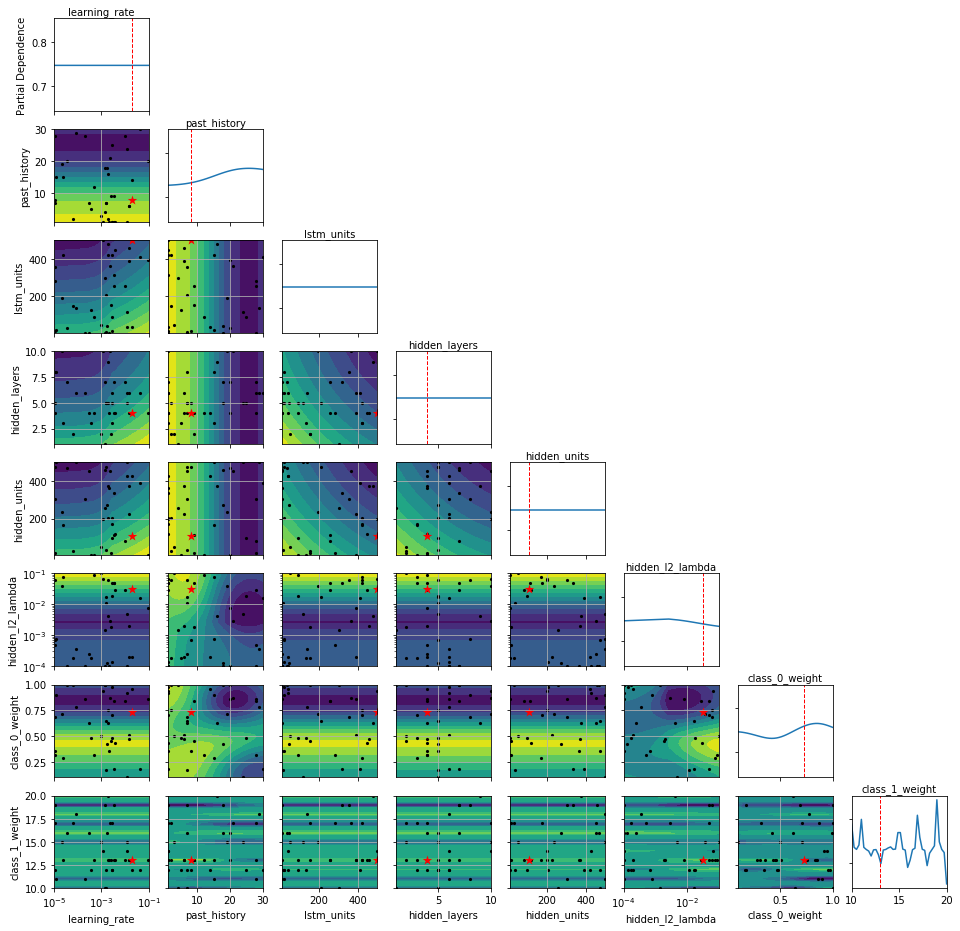

In [19]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

**Try a longer training run with the winning hyperparameters** Some of these, we will manually tweak based on the above graph.

In [20]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.019228596918123494,
 'past_history': 8,
 'lstm_units': 500,
 'hidden_layers': 4,
 'hidden_units': 106,
 'hidden_l2_lambda': 0.03213657950349155,
 'class_0_weight': 0.7284911588284246,
 'class_1_weight': 13}

In [57]:
learning_rate = 0.0009
past_history = 2
lstm_units = winning_hyperparams['lstm_units']
hidden_layers = winning_hyperparams['hidden_layers']
hidden_units = winning_hyperparams['hidden_units']
hidden_l2_lambda = 0.1
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']

future_target = 1
step = 1

initial_bias = -1.4
output_bias = tf.keras.initializers.Constant(initial_bias)
    
class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 100
BATCH_SIZE = 400
STEPS_PER_EPOCH = (len(training_data) * 0.99) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 0.99) // BATCH_SIZE

In [58]:
x_train, y_train = multivariate_data(
    training_data, 
    training_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % BATCH_SIZE))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = multivariate_data(
    validation_data, 
    validation_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % BATCH_SIZE))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

input_dim = x_train.shape[-2:]

input_shape = (BATCH_SIZE, input_dim[0], input_dim[1])

In [59]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    lstm_units,
    batch_input_shape=input_shape,
#         bias_initializer=keras.initializers.VarianceScaling(
#             scale=1.0,
#             mode='fan_in', 
#             distribution='normal', 
#             seed=None
#         ),
#         kernel_regularizer=keras.regularizers.l2(lstm_l2_lambda),
#         activation = 'relu',
     stateful = True
))
for i in range(hidden_layers):
    model.add(keras.layers.Dense(
        hidden_units,
        bias_initializer=keras.initializers.VarianceScaling(
            scale=1.0,
            mode='fan_in', 
            distribution='normal', 
            seed=None
        ),
        kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
        activation = 'relu'
    ))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate), 
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [60]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [early_stopping],
    validation_data=(x_validation, y_validation),
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    workers=8,
    verbose=0
)

model.save('../trained_models/best_single_stateless_LSTM.keras')

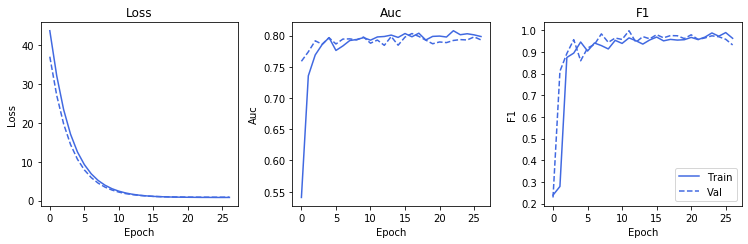

In [61]:
plot_metrics(history)

In [62]:
predictions = model.predict(x_train)

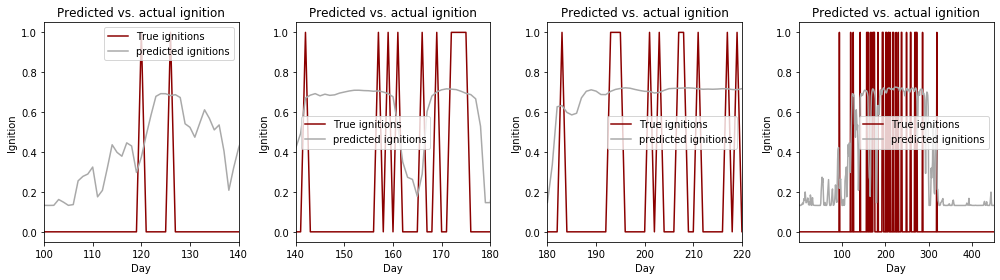

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1,3,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(100,140)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label = 'predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(140,180)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(180,220)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label = 'True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label = 'predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(1,450)

plt.tight_layout()
plt.savefig('../figures/single_stateless_LSTM_training_predictions.png', bbox_inches='tight')
plt.show()

In [64]:
x_testing, y_testing = multivariate_data(
    test_data, 
    test_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_testing.shape[0] - (x_testing.shape[0] % BATCH_SIZE))
end_index = x_testing.shape[0]
x_testing = np.delete(x_testing, range(start_index, end_index), axis=0)
y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

In [65]:
predictions = model.predict(x_testing)

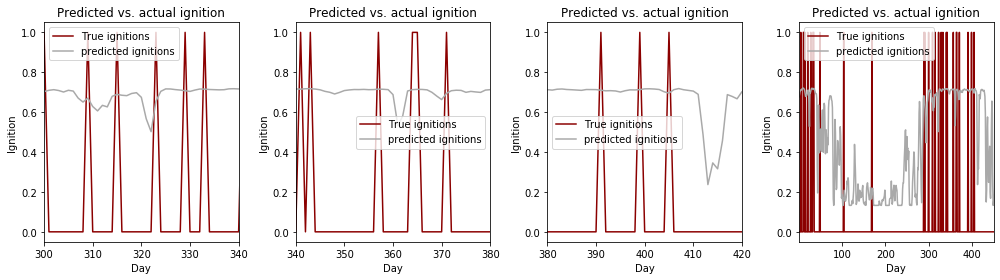

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1,3,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(y_testing)), 
    y_testing,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_testing)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(300,340)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(y_testing)), 
    y_testing,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_testing)), 
    predictions,
    color = "darkgray",
    label = 'predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(340,380)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(y_testing)), 
    y_testing,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_testing)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(380,420)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(y_testing)), 
    y_testing,
    color = "darkred",
    label = 'True ignitions'
)
plt.plot(
    range(len(y_testing)), 
    predictions,
    color = "darkgray",
    label = 'predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(1,450)

plt.tight_layout()
plt.savefig('../figures/single_stateless_LSTM_testing_predictions.png', bbox_inches='tight')
plt.show()

loss :  0.89710333943367
tp :  48.0
fp :  316.0
tn :  433.0
fn :  3.0
accuracy :  0.60125
precision :  0.13186814
recall :  0.9411765
auc :  0.8269458
f1 :  1.0990338
No fire (True Negatives):  433
False alarms (False Positives):  316
Fires missed (False Negatives):  3
Fires detected (True Positives):  48
Total fires:  51


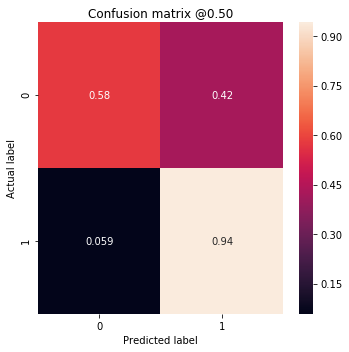

In [67]:
test_predictions = model.predict(x_testing)

results = model.evaluate(
    x_testing,
    y_testing, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plot_cm(y_testing, test_predictions)